# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [2]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [3]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [4]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer, we just need to add the words as list of sentences, document structure doesn't matter, yet:

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [7]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([ 0.7163112 , -0.27030507,  0.20511296,  0.11899061, -0.14852801,
       -0.8195412 , -0.01045112,  0.57361954,  0.55662805, -1.1327517 ,
       -2.7135878 ,  2.3849154 ,  0.86269903, -0.2047039 ,  1.0450975 ,
       -0.68486714,  0.9930152 , -1.689806  , -0.8390746 , -1.2919767 ,
       -0.15880185,  0.434782  ,  0.99531096, -1.7759023 , -1.0116516 ,
       -1.8372189 , -2.5869198 , -1.8895346 , -2.1619043 ,  1.2294215 ,
       -2.082736  , -1.6582644 , -0.85018915,  0.84829706, -0.47882575,
        2.472538  , -1.5048754 ,  0.2739133 , -3.6158073 , -0.15479076,
       -0.41023132,  0.45382068,  0.44755283, -0.4155306 ,  0.69290185,
       -1.011492  , -2.9263303 ,  1.2520202 , -2.131597  , -0.8168338 ,
       -1.7780899 , -0.3051744 ,  1.2866609 , -2.907819  ,  0.16094062,
        0.34773237, -0.23201084,  0.74973744, -0.8748828 , -2.4697685 ,
        0.2305245 , -0.4248431 , -1.4589674 , -0.39477614, -0.926431  ,
        2.5565763 ,  0.17938726,  1.3481032 ,  1.9203951 , -0.21

If you want the full matrix, `syn0` stores all the vectors:

In [8]:
senReleasesW2V.wv.syn0

array([[ 1.9267011 ,  1.1604683 ,  0.6900313 , ...,  0.08003815,
        -0.923128  ,  1.0164331 ],
       [-1.1107249 , -1.5782441 , -0.70186484, ..., -0.6365732 ,
        -0.08518691,  1.3272204 ],
       [ 1.272519  ,  0.5723983 ,  1.4264464 , ...,  1.5761117 ,
        -0.56488633,  0.96823806],
       ...,
       [-0.06178803, -0.03972618, -0.00554367, ...,  0.11014375,
        -0.05829578, -0.11205539],
       [-0.03076702,  0.00364407,  0.05473519, ...,  0.01231027,
         0.03010002, -0.0241845 ],
       [-0.07884979, -0.03165941, -0.01036727, ...,  0.08917592,
        -0.0655165 , -0.102088  ]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [9]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [10]:
senReleasesW2V.most_similar('president')

[('administration', 0.7734898328781128),
 ('presidents', 0.7153295278549194),
 ('administrations', 0.6996356248855591),
 ('george', 0.5924667119979858),
 ('cheney', 0.5731922388076782),
 ('rollback', 0.529650092124939),
 ('responds', 0.5246984958648682),
 ('quoting', 0.5149268507957458),
 ('ronald', 0.5105453729629517),
 ('gop', 0.5052642822265625)]

In [11]:
senReleasesW2V.most_similar('war')

[('wars', 0.6740375757217407),
 ('quagmire', 0.6424829959869385),
 ('disobedience', 0.6394466161727905),
 ('battle', 0.6356610059738159),
 ('afghanistan', 0.6302934885025024),
 ('militarily', 0.6186259984970093),
 ('chaos', 0.6140038371086121),
 ('descending', 0.6115912199020386),
 ('insurgency', 0.592289924621582),
 ('invasion', 0.5881451964378357)]

Find which word least matches the others within a word set (cosine similarity):

In [12]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [13]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6756974458694458),
 ('vetoed', 0.6749100685119629),
 ('bushs', 0.6604385375976562),
 ('veto', 0.6560375094413757),
 ('signature', 0.6313803791999817),
 ('vetoes', 0.6242896318435669),
 ('proposing', 0.6196639537811279),
 ('blocked', 0.61372971534729),
 ('signed', 0.5905942916870117),
 ('desk', 0.5902323722839355)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [14]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [15]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [16]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 1.9267011 ,  1.1604683 ,  0.6900313 , ...,  0.08003815,
        -0.923128  ,  1.0164331 ],
       [-1.1107249 , -1.5782441 , -0.70186484, ..., -0.6365732 ,
        -0.08518691,  1.3272204 ],
       [ 1.272519  ,  0.5723983 ,  1.4264464 , ...,  1.5761117 ,
        -0.56488633,  0.96823806],
       ...,
       [ 0.2067481 ,  0.13176045,  0.00212248, ...,  0.80534697,
        -0.36469454,  0.5151203 ],
       [ 0.46758786,  0.23690887, -0.03946251, ...,  0.03055216,
         0.12582909,  0.66757137],
       [-0.46805856, -1.1568767 , -0.02183603, ..., -0.53662163,
        -0.6577313 ,  0.4732822 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [17]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

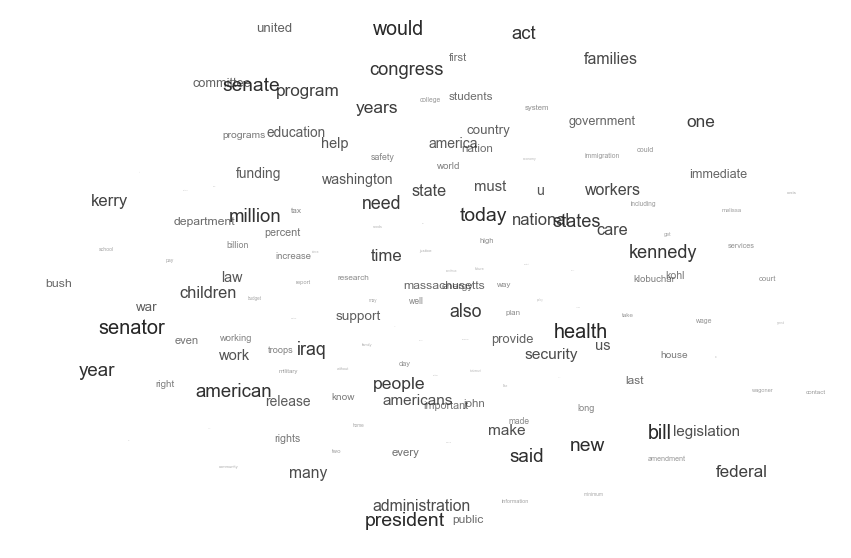

In [18]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.png'>

What if a new senator come along with whose names starts with K? Could we analys there releases too without rerunning the whole embeding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [19]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest, this can update all the weights in the w2v so be careful.

In [20]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this we need to load our old copy to do a comparison

In [21]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [22]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([ 0.44749415, -0.6122871 ,  0.09242933, -0.14960362, -0.13560301,
       -0.8244725 , -0.348225  ,  0.3728538 ,  0.9020584 , -1.3812377 ],
      dtype=float32)

In [23]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([ 0.7163112 , -0.27030507,  0.20511296,  0.11899061, -0.14852801,
       -0.8195412 , -0.01045112,  0.57361954,  0.55662805, -1.1327517 ],
      dtype=float32)

In [24]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([ 0.26881707,  0.34198204,  0.11268363,  0.26859424, -0.012925  ,
        0.00493127,  0.3377739 ,  0.20076576, -0.34543037,  0.24848604],
      dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [25]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

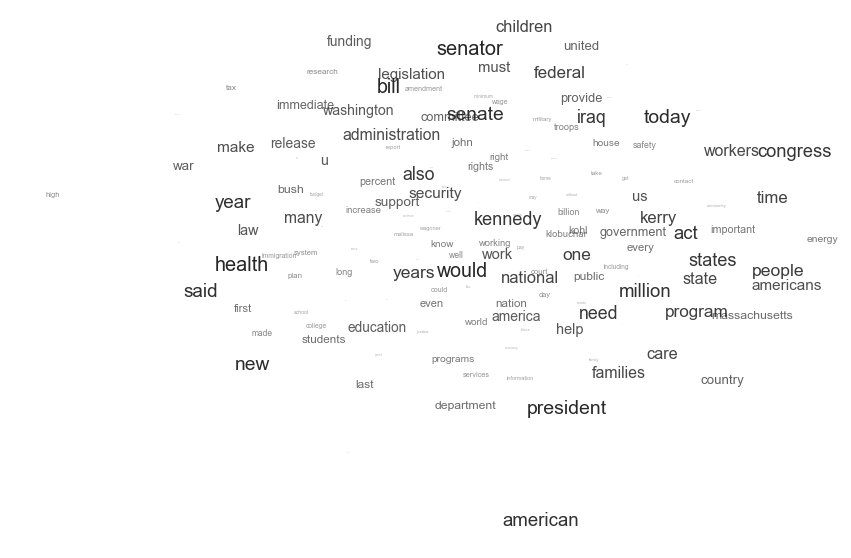

In [26]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Lets tart by training a new model, but this time we will expose most of the options and train it one epoch at a time, to see what they do look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec): 

In [27]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1977830.625

Now we have the training loss and can optimize to minimize it

In [28]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

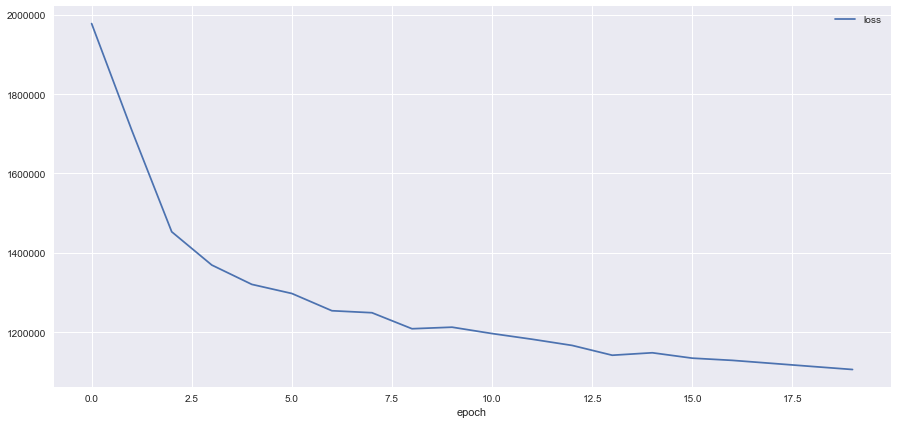

In [29]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run that looks to be around 8 or 9. So if we were to do another analysis we might use an `iter=9` instead of the default 5.

# Chinese examples

In [32]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [33]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [34]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [35]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [36]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [37]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [60]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [61]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [62]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [63]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [64]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [65]:
apsD2V.docvecs[1952]

array([ 0.5138694 ,  0.6089756 , -0.8923166 ,  0.84502685,  0.21872151,
        1.1472459 ,  0.8484326 ,  0.47716796, -0.8258224 , -1.8073959 ,
       -1.8243148 , -0.37067416,  0.9234723 ,  0.8267591 ,  0.89160585,
       -0.58457154,  0.5334008 , -0.68082654,  0.5718233 , -0.13884394,
        1.0663311 , -0.6548069 ,  0.8214362 , -1.143864  ,  0.272146  ,
       -0.43866962, -0.4381678 , -0.41542596, -1.2354627 , -1.7987038 ,
        1.0742887 , -1.1459692 ,  0.08409586, -0.04424522, -0.7335247 ,
        1.3614025 ,  1.3775339 , -1.2994735 , -0.39760447,  0.8372862 ,
       -1.7883937 ,  0.8610892 , -0.27878237,  1.2395762 , -1.2436297 ,
        1.5777966 ,  1.2469579 ,  1.6620514 ,  0.86931014,  0.00403475,
       -0.08082567,  0.720681  ,  1.3459347 , -0.2526604 , -1.4554443 ,
       -0.12678249, -0.14702809, -0.41519094,  0.8790971 ,  0.6505345 ,
        0.6216034 , -1.5097052 , -0.2842992 , -1.1222787 ,  0.6017056 ,
        1.2519753 ,  0.35387427,  0.8702023 ,  0.9696681 ,  0.35

The words can still be accessed in the same way:

In [66]:
apsD2V['atom']

array([-0.08382767, -0.08916173, -0.2181705 ,  0.45573103,  0.42415774,
        0.20621899,  0.5340982 ,  0.7057877 , -0.90834975, -0.02338306,
       -0.4495997 ,  0.67240375,  0.3510015 ,  0.13980329,  0.1766536 ,
       -0.02787095,  0.6673123 ,  0.49674258,  0.31448558, -0.10415918,
        0.70980924, -0.11299654,  0.16907853, -0.7760812 ,  0.45573393,
       -0.7761114 ,  0.5089291 ,  0.01788778, -0.3437804 , -0.82009274,
       -0.12523538, -1.5324267 ,  0.38359582, -0.24269632,  0.15204842,
        0.5161475 ,  0.5083034 , -0.7720538 ,  0.2325692 ,  0.07985671,
       -0.5428875 ,  0.8720586 ,  0.2946146 , -0.29658705,  0.08912594,
        0.49996465, -0.72758716,  0.4952781 ,  0.5323306 ,  0.22822909,
       -0.191333  , -0.23056324,  0.22864974,  0.51469374, -0.31244037,
        0.63240206,  0.77480537,  0.02017507,  0.79917437,  0.6827487 ,
        0.60114604, -0.9142528 ,  0.31243527,  0.14943005,  0.4877385 ,
        1.1768216 ,  0.5853    ,  0.6921193 , -0.57566184,  0.44

We can still use the ``most_similar`` command to perform simple semantic equations:

In [67]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.8004531860351562)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [68]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('schrieffer', 0.9639554619789124)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [69]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.6167968]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [70]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.105.1459', 0.6599565744400024),
 ('10.1103/PhysRev.102.369', 0.6571571826934814),
 ('10.1103/PhysRev.101.1679', 0.6524979472160339),
 ('10.1103/PhysRev.113.91', 0.648259162902832),
 ('10.1103/PhysRev.99.430', 0.6278976202011108)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [71]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('gauss', 0.7711620926856995),
 ('discontinuously', 0.755506694316864),
 ('electric', 0.7517629861831665),
 ('larmor', 0.7246891260147095),
 ('gyromagnetic', 0.7124606370925903)]

We can even look for documents most like a query composed of multiple words:

In [72]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.8200272917747498),
 ('10.1103/PhysRev.91.299', 0.808261513710022),
 ('10.1103/PhysRev.109.1193', 0.8017605543136597),
 ('10.1103/PhysRev.85.120', 0.7842383980751038),
 ('10.1103/PhysRev.101.388', 0.7792898416519165)]

Now let's plot some words and documents against one another with a heatmap:

In [73]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

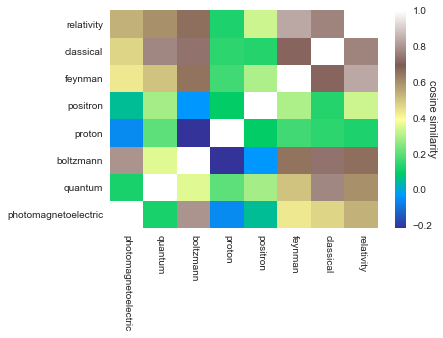

In [74]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [75]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

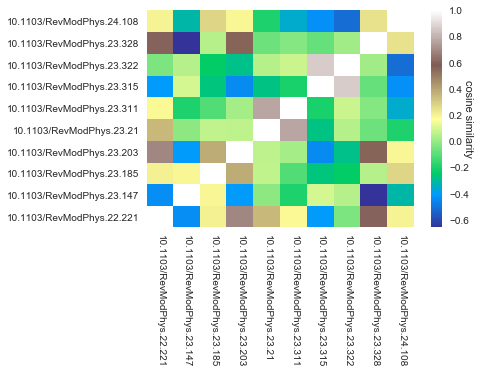

In [76]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [77]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

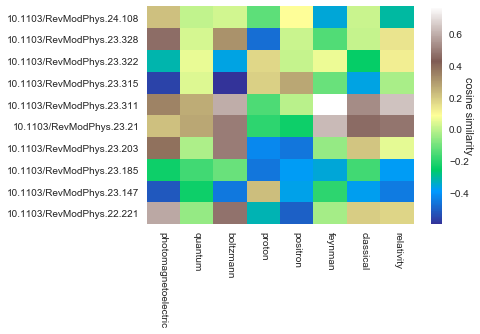

In [78]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [79]:
apsD2V.save('apsW2V')

We can later load it:

In [80]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

# Linguistic Change

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [70]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists. First we load the data:

In [42]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts_reduced.csv", index_col=0)

Then we process it

In [43]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

Then for each year we create a word2vec embedding

In [45]:
embeddingYears = {}
for year in set(ascoDF['Year']):
    print("Embedding {}".format(year), end = '\r')
    subsetDF = ascoDF[ascoDF['Year'] == year]
    embeddingYears[year] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())

In [71]:
smart_procrustes_align_gensim(embeddingYears[1995], embeddingYears[2011])

Do a matrix for one word, e.g., "breast" that looks for changes over the whole period
Then look for the word that changes the most over the whole period (sum of dimension changes)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [ ]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [ ]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [ ]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [ ]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()